# Grasp Detection

### Comp 341

### Imports

In [10]:
import os
import multiprocessing
import numpy as np 
import time
import cv2
from PIL import Image

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm
# from tqdm.std import tqdm, trange
# from tqdm import notebook
# notebook.tqdm = tqdm
# notebook.trange = trange

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torch.optim as optim
torch.backends.cudnn.benchmark = True 
import torchvision as tv

from visualisation import cv2_imshow, rotated_rectangle, imshow
from rect_metric import compare_grasps, grasp_accuracy


print("Using torch", torch.__version__)

Using torch 1.10.0+cu111


In [62]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

In [127]:
# Fetching the device that will be used throughout this notebook

try:
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_PATH = "drive/MyDrive/Liverpool/Assignments/Year 3/COMP341/COMP341 - Assignment 01 - Data/Data/"
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
    !pip install shapely
except:
    print('not in drive')
    DATASET_PATH = 'ass1_data/Data'
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:1")
print("Using device", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device cuda:0


In [13]:
featureExtractionPretrainModel = 'model.pretrain.json'
finalModel = 'finalmodel.json'

### Load Dataset

Expanding the dataset with background augmentation

In [128]:
root_dir = DATASET_PATH + "training"
bk_dir = DATASET_PATH + "../../backgrounds" # Path to background images
num_bk = len(os.listdir(bk_dir)) # Number of background images

# for object_name in os.listdir(root_dir):
#     for scene_index in range(5):

#         scene_root = f"{root_dir}/{object_name}/{scene_index}_{object_name}_"

#         # Make sure a scene with this index exists for this object
#         rgb_path = scene_root + "RGB.png"
#         if not os.path.exists(rgb_path): continue

#         # Load original image and mask
#         rgb = cv2.imread(rgb_path)
#         mask = cv2.imread(scene_root + "mask.png")

#         for bk_index, background in enumerate(os.listdir(bk_dir)):

#             # Load the background image
#             bk = cv2.imread(os.path.join(bk_dir, background))[:1024, :1024]

#             # get masked foreground
#             fg_masked = cv2.bitwise_and(rgb, mask)

#             # get masked background, mask must be inverted 
#             mask = cv2.bitwise_not(mask)
#             bk_masked = cv2.bitwise_and(bk, mask)
#             mask = cv2.bitwise_not(mask)  # revert mask to original

#             # combine masked foreground and masked background 
#             final = cv2.bitwise_or(fg_masked, bk_masked)
#             cv2.imwrite(scene_root + f"RGB{bk_index}.png", final)

In [129]:
class GraspDataset(td.Dataset):
  def __init__(self, root_dir, transforms=None, depth_image=None):
      self.root_dir = root_dir
      self.depth_image = {'perfect':'pDepth', 'stereo': 'sDepth'}.get(depth_image)
      self.transforms = transforms if transforms else tv.transforms.Compose([tv.transforms.ToTensor()])

      # List of all scenes for all objects in the dataset
      self.scene_paths = []
      for object_name in os.listdir(root_dir):
        scene_nums = os.listdir(f"{root_dir}/{object_name}")
        scene_nums = set([file.split("_")[0] for file in scene_nums])
        for scene_index in scene_nums: # Scene index ranges from 0 to 4 for all objects
          scene_root = f"{root_dir}/{object_name}/{scene_index}_{object_name}_"

          # Make sure a scene with this index exists for this object
          grasp_path = scene_root + "grasps.txt"
          if os.path.exists(grasp_path):
            processLine = lambda line: np.array([float(number) for number in line.split(";")])
            with open(grasp_path) as file:
              grasps = np.array([processLine(line) for line in file.readlines()], dtype=np.float32)
          else:
            raise Exception(f"grasp file does not exist!! ({grasp_path})")

          # For each grasp in the scene
          for grasp in grasps:

            # For each RGB image in the scene
            for bk_index in range(num_bk+1): # +1 for the original image

              # If the background index raches the number of backgrounds, set it
              # to an empty string to load the original image
              if bk_index == num_bk: bk_index = ""
              
              scene = {
                "grasp": grasp,
                "rgb": scene_root + f"RGB{bk_index}.png",
                "mask": scene_root + "mask.png",
                "pDepth": scene_root + "perfect_depth.tiff",
                "sDepth": scene_root + "stereo_depth.tiff"
              }
              self.scene_paths.append(scene)

  # This must return the length of the dataset
  def __len__(self):
    return len(self.scene_paths)

  # This must return the single dataset item at index idx
  def __getitem__(self, idx):
    grasp = self.scene_paths[idx]['grasp'] #load a grasp
    # Load the RGB image
    image = Image.open(self.scene_paths[idx]["rgb"])
    if self.transforms: #do transforms
        image = self.transforms(image)

    if self.depth_image is not None:
      depth = Image.open(self.scene_paths[idx][self.depth_image])
      return (image, depth, grasp)

    return (image, grasp)

In [16]:
def save_tensor_image(img):
    image = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(image)
    image = image.permute(1, 2, 0).numpy().astype('uint8')
    image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2RGB)

### Lets look at an image

grasp: tensor([544.6839, 561.4836,  49.2777, 136.5000,  12.7588])


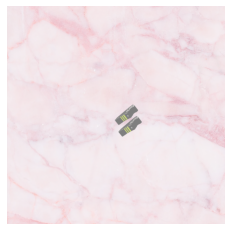

In [133]:
# Show off the dataset
dataset = GraspDataset(DATASET_PATH + "/training")
# print(len(dataset))
# indicies = list(range(len(dataset)))[125:]
# dataset = torch.utils.data.Subset(dataset, indicies)
loader = td.DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False, num_workers=2)
batch = next(iter(loader))
imshow(batch[0][0])

print("grasp:", batch[1][0])
# print("depth:", batch[1][index])

## Boilerplate Code

### helpers

In [ ]:
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_epochs(train_history, validation_history=None, plotType="loss"):
    x = np.arange(1, len(train_history) + 1)
    plt.figure(figsize=(8, 6))
    if validation_history:
        plt.plot(x, validation_history, color=colors[1], label=f"Validation {plotType}", linewidth=2)
    plt.plot(x, train_history, color=colors[0], label=f"Training {plotType}", linewidth=2)
    plt.ylabel(f'{plotType}')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title(f"Evolution of the training and validation {plotType}")
    plt.show()

In [ ]:
def get_cnn_output_size(in_size, kernel_size, stride=1, padding=0):
    integer = int((in_size - kernel_size + 2 * padding) / stride) == ((in_size - kernel_size + 2 * padding) / stride)
    if not integer:
        print("not int", ((in_size - kernel_size + 2 * padding) / stride))
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

In [ ]:
get_cnn_output_size(64, kernel_size=3, stride=2, padding=0)

not int 30.5


31

### loss and optimisers

In [ ]:
def getLoss(regression=True):
    if regression:
        return nn.MSELoss()
    else:
        return nn.CrossEntropyLoss()

def getOptimiser(model, learningRate):
    #optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimiser = optim.Adam(model.parameters(), lr=learningRate)
    return optimiser

### Data Loaders

In [ ]:
def gen_transforms(resize=None, imgs_mean=(0.5,), imgs_std=(0.5,)):
    tst_trans = [tv.transforms.ToTensor()]
    if resize is not None:
        tst_trans.append(tv.transforms.Resize(resize[0]))
        tst_trans.append(tv.transforms.CenterCrop(resize[1]))
    tst_trans.append(tv.transforms.Normalize(mean=imgs_mean, std=imgs_std))
    return tv.transforms.Compose(tst_trans)

def get_train_loader(batchSize, resize = None, dataset='grasp'): # dataset can = ('grasp', 'perfectDepth', 'stereoDepth', or 'imageNet')
    transforms = gen_transforms(resize)
    if dataset == 'imageNet':
        trainData = tv.datasets.ImageNet(root=f'imageNet/', transform=transforms, split='val')
        imagenetSampler = torch.utils.data.RandomSampler(trainData, num_samples=1000)
        trainLoader = td.DataLoader(trainData, batch_size=batchSize, sampler=imagenetSampler, shuffle=False, drop_last=False, num_workers=int(multiprocessing.cpu_count()/2))
    else:
        trainData = GraspDataset(root_dir=f'{DATASET_PATH}/training', transforms=transforms, depth_image={'perfectDepth':'perfect', 'stereoDepth':'stereo', 'grasp':None}.get(dataset))
        trainLoader = td.DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=False, num_workers=int(multiprocessing.cpu_count()/2))
    return trainLoader


### Training function

In [ ]:
def train(model, batch_size, n_epochs, learning_rate, resize=None, mode = 'train'): #mode = 'pretrain' or 'train'
    print(f"batch size: {batch_size}")
    print(f"n epochs: {n_epochs}")
    print(f"learning rate: {learning_rate}")
    print("="*20)
    
    trainLoader = get_train_loader(batch_size, resize, 'grasp' if mode == 'train' else 'imageNet')
    lossFn = getLoss(mode == 'train')
    optimizer = getOptimiser(model, learning_rate)

    train_history = []
    accuracy_history = []
    training_start_time = time.time()
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)
    if mode == 'pretrain':
        model.featureExtractionBlock.load_state_dict(torch.load(featureExtractionPretrainModel))

    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss = 0
        epoch_accuracy = 0

        with tqdm(trainLoader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for rgb, grasp in tepoch:   #for each batch
                rgb, grasp = rgb.to(device), grasp.to(device)   # Move tensors to gpu
                optimizer.zero_grad()   # zero the parameter gradients

                # forward + backward + optimize
                outputs = model(rgb)    
                loss = lossFn(outputs,  grasp)
                loss.backward()
                optimizer.step()
                # add to running totals
                epoch_loss += loss.item()
                with torch.no_grad():
                    accs = grasp_accuracy(outputs, grasp) if mode == 'train' else 0.0
                    epoch_accuracy += accs
        epoch_loss = epoch_loss / len(trainLoader)
        # print(f"Epoch #{epoch + 1} train_loss: {round(epoch_loss,2)} accuracy: {round(epoch_accuracy,1)}% took: {round(time.time() - start_time,2)}s") 
        train_history.append(epoch_loss)
        batch_acc = epoch_accuracy/len(trainLoader)
        accuracy_history.append(batch_acc)
    if mode == 'train':
        with torch.no_grad():
            for i in range(batch_size):
                print('predicted:', outputs[i].cpu())
                rotated_rectangle(rgb[i].cpu(), outputs[i].cpu(), grasp[i].cpu())
            accuracy_history = [i.cpu().numpy().item() for i in accuracy_history]
    elif mode == 'pretrain':
        torch.save(model.featureExtractionBlock.state_dict(), featureExtractionPretrainModel)
    print(accuracy_history)
    print(f"Training Finished, took {round(time.time() - training_start_time,1)}s")
    return train_history, accuracy_history

In [ ]:
def train_depth(model, batch_size, n_epochs, learning_rate, resize=None):
    print(f"batch size: {batch_size}")
    print(f"n epochs: {n_epochs}")
    print(f"learning rate: {learning_rate}")
    print("="*20)
    
    trainLoader = get_train_loader(batch_size, resize, dataset="perfectDepth")
    lossFn = getLoss()
    optimizer = getOptimiser(model, learning_rate)

    train_history = []
    accuracy_history = []
    training_start_time = time.time()
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)

    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss = 0
        epoch_accuracy = 0
        
        with tqdm(trainLoader, unit="batch") as tepoch:
            for rgb, depth, grasp in tepoch:   #for each batch
                tepoch.set_description(f"Epoch {epoch}")
                # Move tensors to gpu
                rgb, depth, grasp = rgb.to(device), depth.to(device), grasp.to(device)
               
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = model(rgb, depth)
                loss = lossFn(outputs,  grasp)
                loss.backward()
                optimizer.step()
                # add to running totals
                epoch_loss += loss.item()
                with torch.no_grad():
                    accs = grasp_accuracy(outputs, grasp)
                    epoch_accuracy += accs
        epoch_loss = epoch_loss / len(trainLoader)
        train_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy/len(trainLoader))
    with torch.no_grad():
        accuracy_history = [i.cpu().numpy().item() for i in accuracy_history]
    print(f"Training Finished, took {round(time.time() - training_start_time,1)}s")
    return train_history, accuracy_history

## Our Models

### Conv Net

In [ ]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()

        # Input image is size 1024x1024
        self.conv1 = nn.Conv2d(3, 64, kernel_size=6, stride=2, padding=0) # output is 510x510
        #torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.batchN = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # output is 255x255
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # output is 128x128
        #torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchN2 = nn.BatchNorm2d(128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # output is 64x64
        
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0) # output is 31x31
        #torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchN3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 31 * 31, 5)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batchN(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchN2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.batchN3(x)
        x = F.relu(x)
        x = self.pool2(x)
        # flatten tensor
        x = x.view(x.size()[0], -1)

        x = self.fc1(x)

        return x

### ResNet

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, depth_in, activation_func, depth_out=-1):
        super().__init__()
        self.downSampleResidul = True
        if depth_out == -1:
            depth_out = depth_in
            self.downSampleResidul = False

        self.resBlock = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(inplace=True),
            nn.Conv2d(depth_in, depth_out, kernel_size=3, padding=1, stride=1 if not self.downSampleResidul else 2, bias=False),
            nn.BatchNorm2d(depth_out),
            activation_func(inplace=True),
            nn.Conv2d(depth_out, depth_out, kernel_size=3, padding=1, bias=False)
        )

        self.downsampleRes = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(inplace=True),
            nn.Conv2d(depth_in, depth_out, kernel_size=1, stride=2, bias=False)
        )

    def forward(self, x):
        z = self.resBlock(x)
        if self.downSampleResidul:
            x = self.downsampleRes(x)
        return z + x

In [ ]:
class DeepGraspResNet(nn.Module):
    def __init__(self, mode = 'train', applyFC=True):
        super(DeepGraspResNet, self).__init__()
        self.applyFC = applyFC
        # self.classificationMode = classificationMode
        #in = 1024 x 1024
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=0), #out = 511x511
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(16),
            # nn.Dropout(0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), #out = 509x509
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), #out = 507x507
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0) #out = 253x253
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 253x253
        )

        self.block2 = ResNetBlock(32, nn.SiLU, 64)      #out = 127x127
        self.block3 = ResNetBlock(64, nn.SiLU, 128)     #out = 64x64
        self.block4 = ResNetBlock(128, nn.SiLU, 256)    #out = 32x32
        self.block5 = ResNetBlock(256, nn.SiLU, 256)    #out = 16x16

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  #out = 8x8
        # self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.flattened_size = 256 * 8 * 8

        self.featureExtractionBlock = nn.Sequential(
            self.block1, 
            self.block2, 
            self.block3, 
            self.block4, 
            self.block5
        )

        self.regressionBlock = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.flattened_size, 1024),
            nn.Dropout(0.2),
            nn.SiLU(inplace=True),
            nn.Linear(1024, 5 if mode == 'train' else 1000),
        )
        # self.classification = nn.SoftMax()

    def forward(self, x):
        x = self.featureExtractionBlock(x)
        x = self.pool(x)
        x = x.view(-1, self.flattened_size)
        if self.applyFC:
                x = self.regressionBlock(x)
        return x

### Pretrained resNet

In [ ]:
import torchvision.models as models
def get_pre_trained_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(512, 5)
    return model

### Depth ResNet

In [ ]:
class DeepConvDepthNN(nn.Module):
    def __init__(self):
        super(DeepConvDepthNN, self).__init__()
        self.rgb_side = DeepGraspResNet(applyFC=False)

        #in = 1024 x 1024
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=0), #out = 511x511
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), #out = 509x509
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), #out = 507x507
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0) #out = 253x253
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 253x253
        )
        self.featureExractionBlock = nn.Sequential(
            ResNetBlock(32, nn.SiLU, 64),     #out = 127x127
            ResNetBlock(64, nn.SiLU, 128),    #out = 64x64
            ResNetBlock(128, nn.SiLU, 256),    #out = 32x32
            ResNetBlock(256, nn.SiLU, 256)    #out = 16x16
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.flattened_size = 256 * 8 * 8 #36864

        self.regressionBlock = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.flattened_size, 512),
            nn.Dropout(0.2),
            nn.Linear(512, 5),
            # nn.Linear(2048, 5)
        )

    def forward(self, rgb, x):
        rgb_output = self.rgb_side(rgb)
        x = self.featureExractionBlock(x)
        x = self.pool(x)
        x = x.view(-1, self.flattened_size)
        torch.cat((rgb_output, x))
        x = self.regressionBlock(x)
        return x

## Test Networks

In [ ]:
network = 'DeepResNet' # choices are 'DeepResNet' or 'Conv'
mode = 'train' # choices are 'pretrain' or 'train'

torch.cuda.empty_cache()

if network == 'DeepResNet':
  resize = None # (1047, 1047)
  BATCH_SIZE = 16
  EPOCHS = 20
  LEARNING_RATE = 0.01
  nnet = DeepGraspResNet(mode=mode)
  if mode == 'pretrain':
    resize = (1024, 1024)
    EPOCHS = 10
  # nnet = nn.DistributedDataParallel(nnet)
  # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elif network == 'Conv':
  resize = None
  BATCH_SIZE = 4
  EPOCHS = 8
  LEARNING_RATE = 0.001
  nnet = ConvNN()
elif network == 'PreTrainedResNet':
  nnet = get_pre_trained_model()
  BATCH_SIZE = 8
  EPOCHS = 30
  LEARNING_RATE = 0.000001
elif network == 'depth':
  resize = None # (1047, 1047)
  BATCH_SIZE = 4
  EPOCHS = 8
  LEARNING_RATE = 0.001
  nnet = DeepConvDepthNN()
  train_loss, train_acc = train_depth(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE, resize=resize)

train_loss, train_acc = train(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE, resize=resize, mode=mode)

batch size: 16
n epochs: 20
learning rate: 0.01


  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

  0%|          | 0/189 [00:00<?, ?batch/s]

In [ ]:
def learning_rate_search(lrs):
    results = {}
    for lr in lrs:
        train_loss, train_acc = train(nnet, BATCH_SIZE, EPOCHS, lr, resize=resize, mode=mode)
        results[lr] = (train_loss, train_acc)
    return results
lrResults = learning_rate_search([0.1, 0.01, 0.001, 0.0001, 0.00001])

### loss and accuracy plots

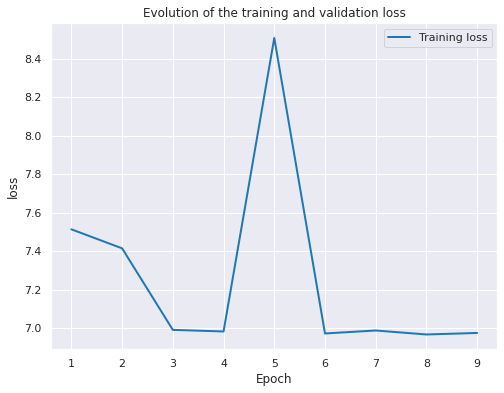

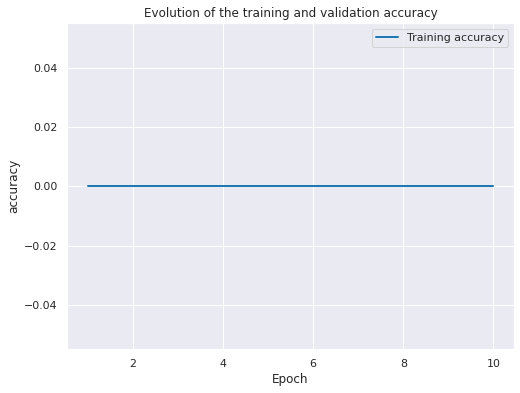

In [ ]:
plot_epochs(train_loss[1:])
plot_epochs(train_acc, plotType="accuracy")